# Research with Word Context Vectors and Congress

#### By Jo Guldi

Workhorse script to use pre-generated Gensim models to study Congressional debates.  

This script does not generate the Gensim models.  For that script, see parallel-congress-embeddings.ipynb

## Import packages

In [318]:
from matplotlib import cm
from numpy import linspace
from matplotlib import pyplot as plt
import numpy as np
from adjustText import adjust_text
from scipy.cluster.hierarchy import dendrogram, linkage #, set_link_color_palette
import matplotlib as matplotlib
import gensim
import os

## Helper Scripts

In [319]:

def color_map_color(value):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color


In [320]:
def flatten_lists(keyword_context):
    all_words = []
    for i in range(0,len(keyword_context)):
        if keyword_context[i]:
            for word_proportion_pair in keyword_context[i]:
                if word_proportion_pair:
                    word = word_proportion_pair[0]
                    if word:
                        all_words.append(word)
                    else:
                        all_words = all_words
                else:
                    all_words = all_words
        else:
            all_words = all_words
            
    return(all_words)

In [321]:
# helper function to remove versions of keyword from embeddings list (e.g. no 'taxation' for 'tax')
def remove_redundancies(keyword1, keyword_context):
    
    keyword_context = [[word for word in period if keyword1[0] not in word] for period in keyword_context]
#    keyword_context = [[word for word in period if len(word) >= 2] for period in keyword_context]


In [322]:
# helper function to abstract only unique values while keeping the list in the same order -- the order of first appearance
def unique2(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [357]:
def get_keyword_context(keyword1, filename1):
    
    global dates_found
    keyword_context = []
    dates_found = []

    for p in range(0,len(periodnames)):

        period1 = periodnames[p]
        print('working on ', period1)
        
        # load gensim period file if it exists
        filename = filename1 + str(period1)
        if os.path.exists(filename):
            period_model = gensim.models.Word2Vec.load(filename) 
        
            ## analysis
            if keyword1 in period_model.wv.vocab:
                print('found ', keyword1)
                
                # get context
                keyword_context_period = period_model.wv.most_similar(keyword1, topn = 5000) # extract the context of how women were talked about in that period
                
                keyword_context.append(keyword_context_period) # save the context of how women were talked about for later
                dates_found.append(period1)
            #else:
              #  dates_found.append([])
              #  keyword_context.append([])

    #k = remove_redundancies(keyword1, keyword_context)

    return(keyword_context)

In [358]:
def get_synonyms(keyword1, keyword_context, filename1, n):
    
        all_synonyms = []
        for p in range(0,len(periodnames)):

            period1 = periodnames[p]
            print('working on ', period1)
        
            # load gensim period file if it exists
            filename = filename1 + str(period1)
            if os.path.exists(filename):
                period_model = gensim.models.Word2Vec.load(filename) 

                ## analysis
                if keyword1 in period_model.wv.vocab:
                    print('found ', keyword1)

                    # get context
                    keyword_context_period = period_model.wv.most_similar(keyword1, topn = 5000) # extract the context of how women were talked about in that period

                    # save context
                    top_keyword_context = [word[0] for word in keyword_context_period[:n]]

                    # generate synonym list
                    sum = period_model.wv[top_keyword_context[0]] 
                    for word in top_keyword_context[1:len(top_keyword_context)]:
                        next_vector = period_model.wv[word] 
                        sum = sum + next_vector

                    synonyms = period_model.wv.similar_by_vector(sum)
                    all_synonyms.append(synonyms)
        return(all_synonyms)

In [344]:
# master visualization tool
def graph_context(keyword_context, periodnames, title1): 

    all_words2 = flatten_lists(keyword_context)
    colors = [ cm.viridis(x) for x in linspace(0, 1, len(unique2(all_words2))+10) ]
    %matplotlib inline
    #from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    from adjustText import adjust_text

    # change the figure's size here
    plt.figure(figsize=(15,15), dpi = 300)

    texts = []

    # plt.annotate only plots one label per iteration, so we have to use a for loop 
    for i in range(0,len(dates_found)):    # cycle through the period names

        if keyword_context[i]:
            
            if len(keyword_context[i]) > 0:
                
                for j in range(10):     # cycle through the first ten words (you can change this variable)

                    xx = periodnames[i]        # on the x axis, plot the period name
                    yy = [item[1] for item in keyword_context[i]][j]         # on the y axis, plot the distance -- how closely the word is related to the keyword
                    txt = [item[0] for item in keyword_context[i]][j]        # grab the name of each collocated word
                    colorindex = unique2(all_words2).index(txt)                 # this command keeps all dots for the same word the same color

                    plt.scatter(                                           # plot dots
                        xx, #x axis
                        yy, # y axis
                        linewidth=1, 
                        color = colors[colorindex],
                        s = 300, # dot size
                        alpha=0.5)  # dot transparency

                    # make a label for each word
                    texts.append(plt.text(xx, yy, txt))

    # Code to help with overlapping labels -- may take a minute to run
    adjust_text(texts, force_points=0.0001, force_text=.07,#0.0035, 
                        expand_points=(1, 1), expand_text=(1, 1),
                        arrowprops=dict(arrowstyle="-", color='black', lw=0.5))


    plt.xticks(rotation=90)

    # Add titles
    plt.title(title1, fontsize=18, fontweight=0, color='Red')
    plt.xlabel("period")
    plt.ylabel("similarity")

In [345]:
startdate = 1870
enddate = 2010 
periods = range(int(startdate),int(enddate)+5,5)
periodnames = []
for period in periods:
    periodnames.append(str(period)+'.0')
periodnames

['1870.0',
 '1875.0',
 '1880.0',
 '1885.0',
 '1890.0',
 '1895.0',
 '1900.0',
 '1905.0',
 '1910.0',
 '1915.0',
 '1920.0',
 '1925.0',
 '1930.0',
 '1935.0',
 '1940.0',
 '1945.0',
 '1950.0',
 '1955.0',
 '1960.0',
 '1965.0',
 '1970.0',
 '1975.0',
 '1980.0',
 '1985.0',
 '1990.0',
 '1995.0',
 '2000.0',
 '2005.0',
 '2010.0']

## Search for One Word

In [334]:
cd '/scratch/group/history/hist_3368-jguldi/congress-embeddings'

/scratch/group/history/hist_3368-jguldi/congress-embeddings


In [335]:
keyword1 = 'woman'  # define the keyword you're looking for. you can change this variable as many times as you want.

In [360]:
filename = 'stopworded-bigrammed-congress-model-' # or 'model-'

In [337]:
keyword_context = get_keyword_context(keyword1, filename)

working on  1870.0
found  woman
working on  1875.0
found  woman
working on  1880.0
found  woman
working on  1885.0
found  woman
working on  1890.0
found  woman
working on  1895.0
found  woman
working on  1900.0
found  woman
working on  1905.0
found  woman
working on  1910.0
found  woman
working on  1915.0
found  woman
working on  1920.0
found  woman
working on  1925.0
found  woman
working on  1930.0
found  woman
working on  1935.0
found  woman
working on  1940.0
found  woman
working on  1945.0
found  woman
working on  1950.0
found  woman
working on  1955.0
found  woman
working on  1960.0
found  woman
working on  1965.0
found  woman
working on  1970.0
found  woman
working on  1975.0
found  woman
working on  1980.0
found  woman
working on  1985.0
found  woman
working on  1990.0
found  woman
working on  1995.0
found  woman
working on  2000.0
found  woman
working on  2005.0
found  woman
working on  2010.0
found  woman


In [339]:
keyword_context[3][0:15]

[('women', 0.7717474102973938),
 ('wife_mother', 0.6146429777145386),
 ('ladi', 0.6010053157806396),
 ('womanhood', 0.5976316332817078),
 ('mother', 0.5927897095680237),
 ('christian', 0.5841220617294312),
 ('wive', 0.5774962902069092),
 ('sex', 0.5725969076156616),
 ('daughter', 0.5651108026504517),
 ('poor_old', 0.5553877353668213),
 ('marri', 0.546595573425293),
 ('poor_woman', 0.5454868674278259),
 ('child', 0.5272027850151062),
 ('virtuou', 0.5270469188690186),
 ('poor_widow', 0.5212393403053284)]

In [340]:
title1 = "What words were used most in the context of ''" + keyword1 +  "' in the Congressional debates?"

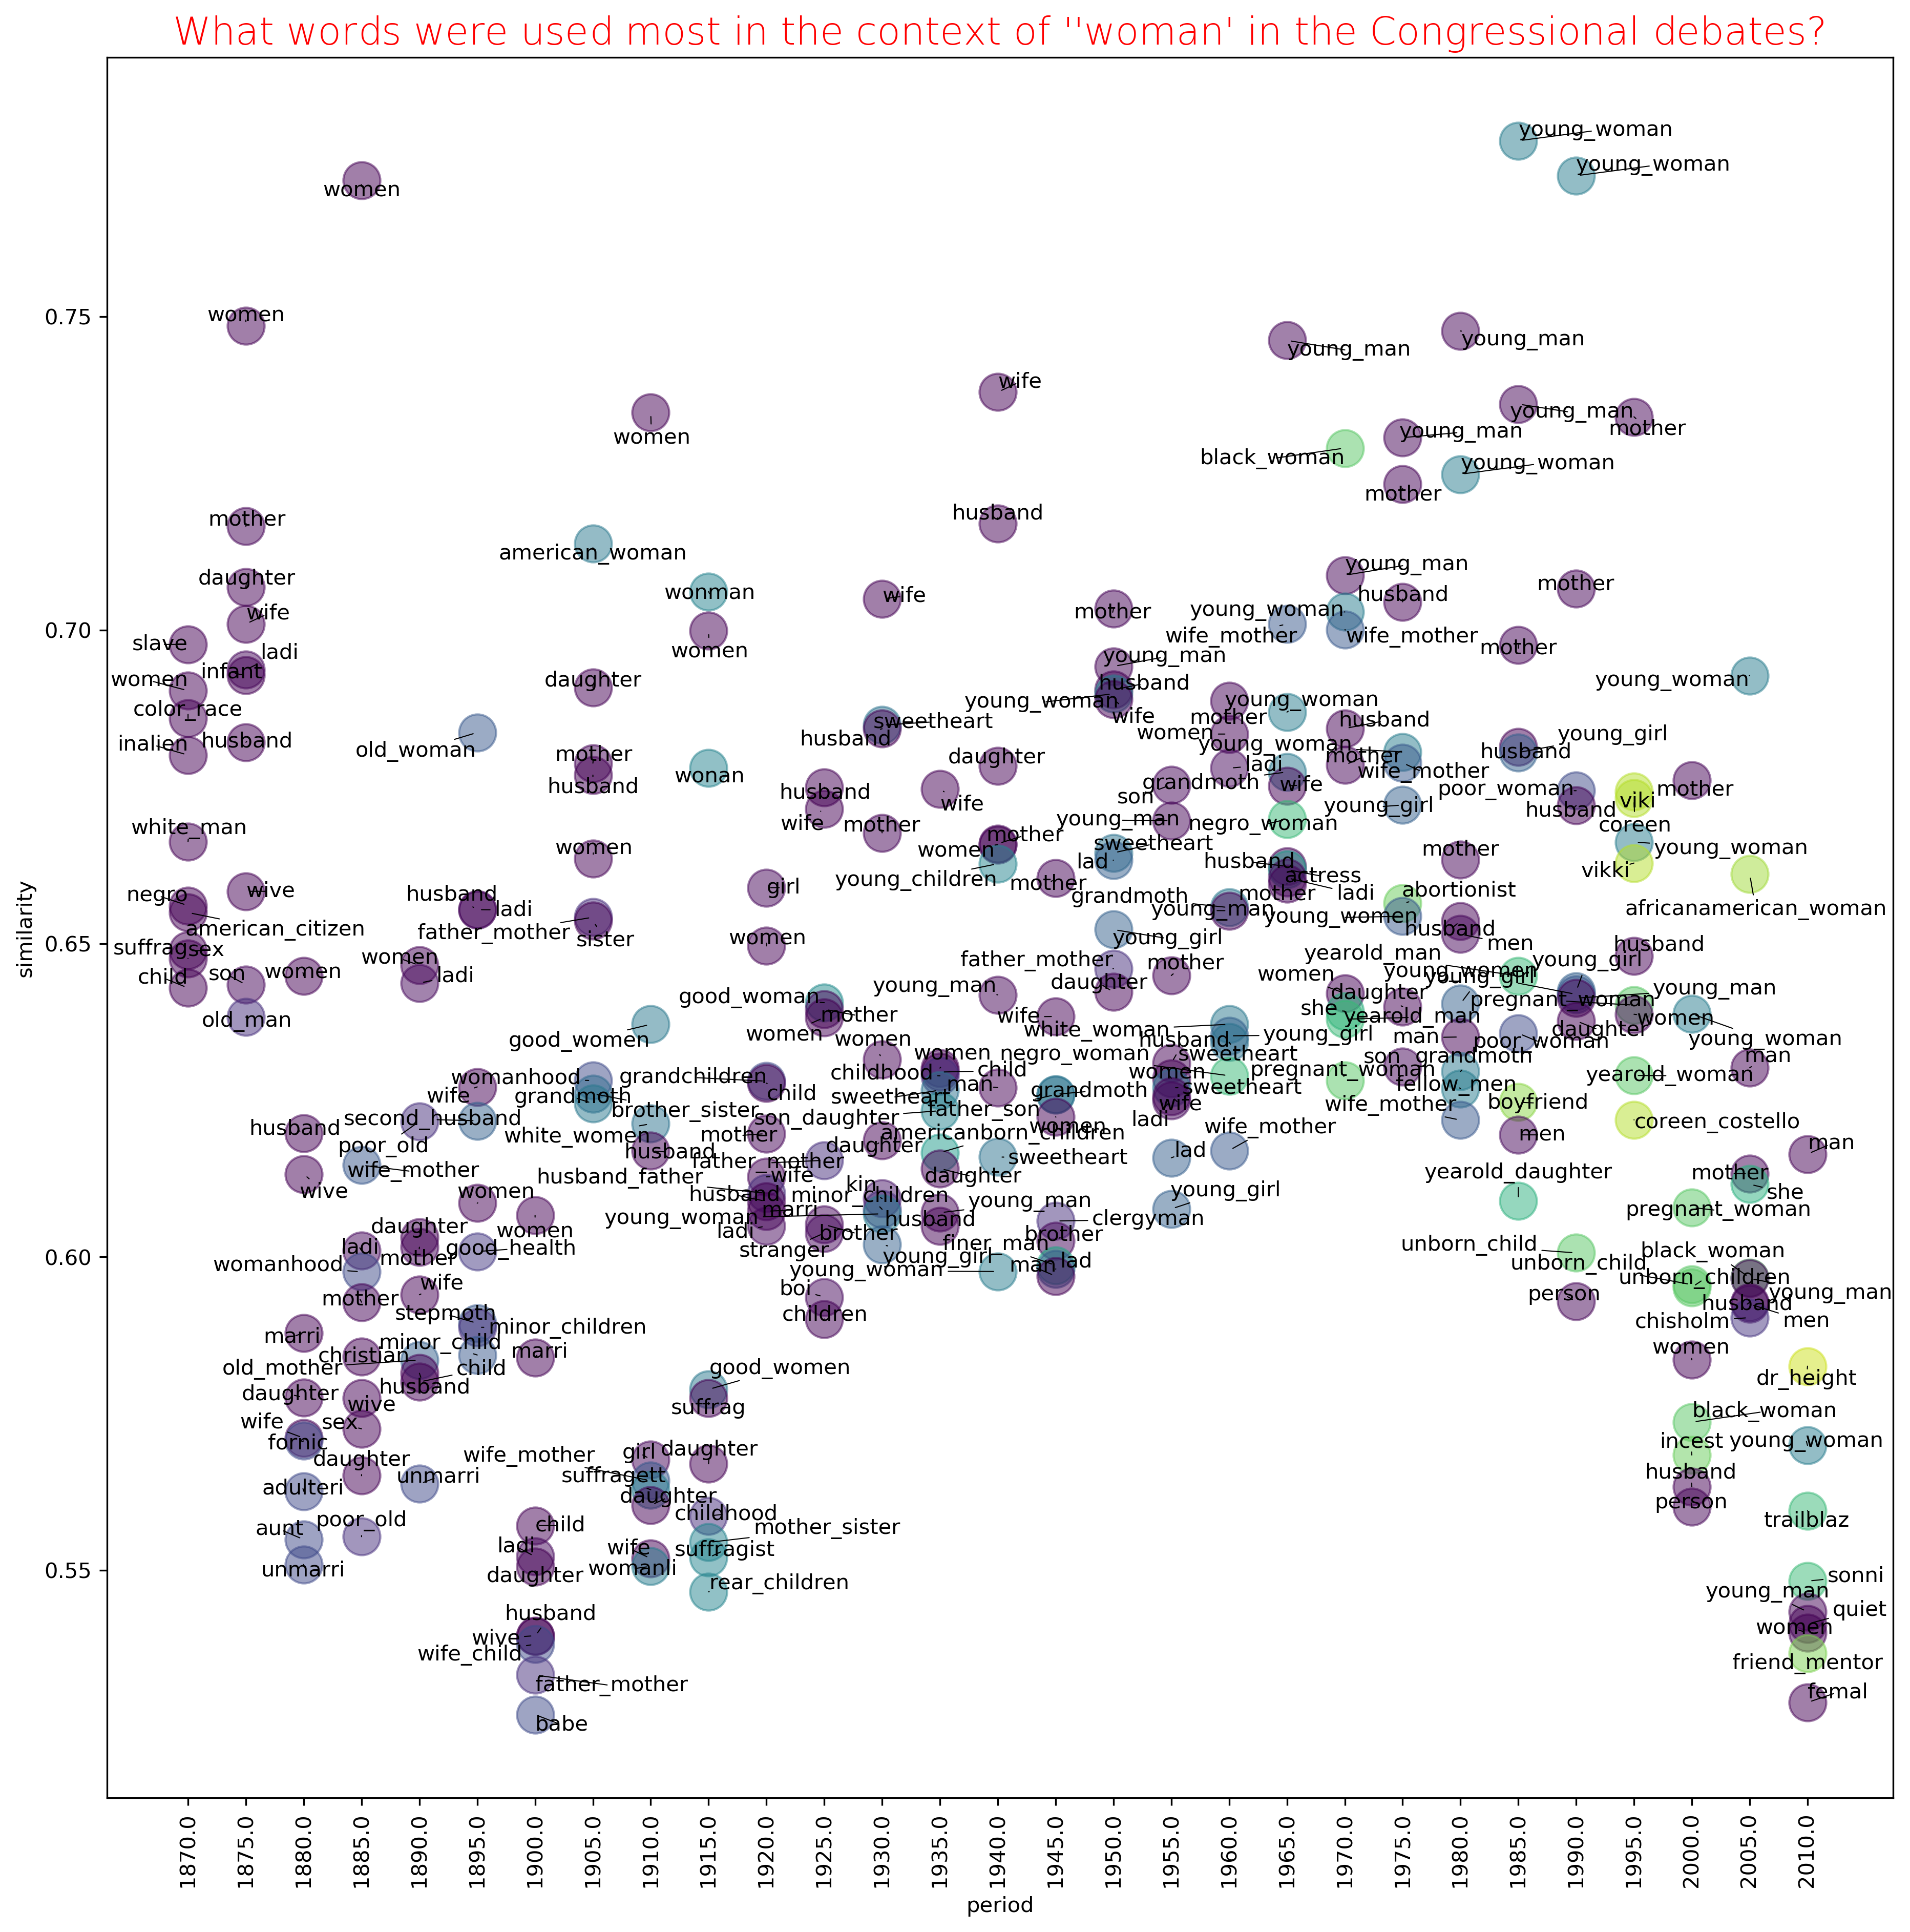

In [341]:
graph_context(keyword_context, periodnames, title1)
plt.savefig(keyword1 + filename + '-context-over-time-' + str(startdate) + '-' + str(enddate) + '.pdf')

## Find Historic Synonyms

In [ ]:
n = 1000

In [367]:
synonyms = get_synonyms(keyword1, keyword_context, filename, n)

working on  1870.0
found  woman
working on  1875.0
found  woman
working on  1880.0
found  woman
working on  1885.0
found  woman
working on  1890.0
found  woman
working on  1895.0
found  woman
working on  1900.0
found  woman
working on  1905.0
found  woman
working on  1910.0
found  woman
working on  1915.0
found  woman
working on  1920.0
found  woman
working on  1925.0
found  woman
working on  1930.0
found  woman
working on  1935.0
found  woman
working on  1940.0
found  woman
working on  1945.0
found  woman
working on  1950.0
found  woman
working on  1955.0
found  woman
working on  1960.0
found  woman
working on  1965.0
found  woman
working on  1970.0
found  woman
working on  1975.0
found  woman
working on  1980.0
found  woman
working on  1985.0
found  woman
working on  1990.0
found  woman
working on  1995.0
found  woman
working on  2000.0
found  woman
working on  2005.0
found  woman
working on  2010.0
found  woman


In [368]:
title2 = "What words functioned as virtual synonyms for ''" + keyword1 +  "' in the Congressional debates?"

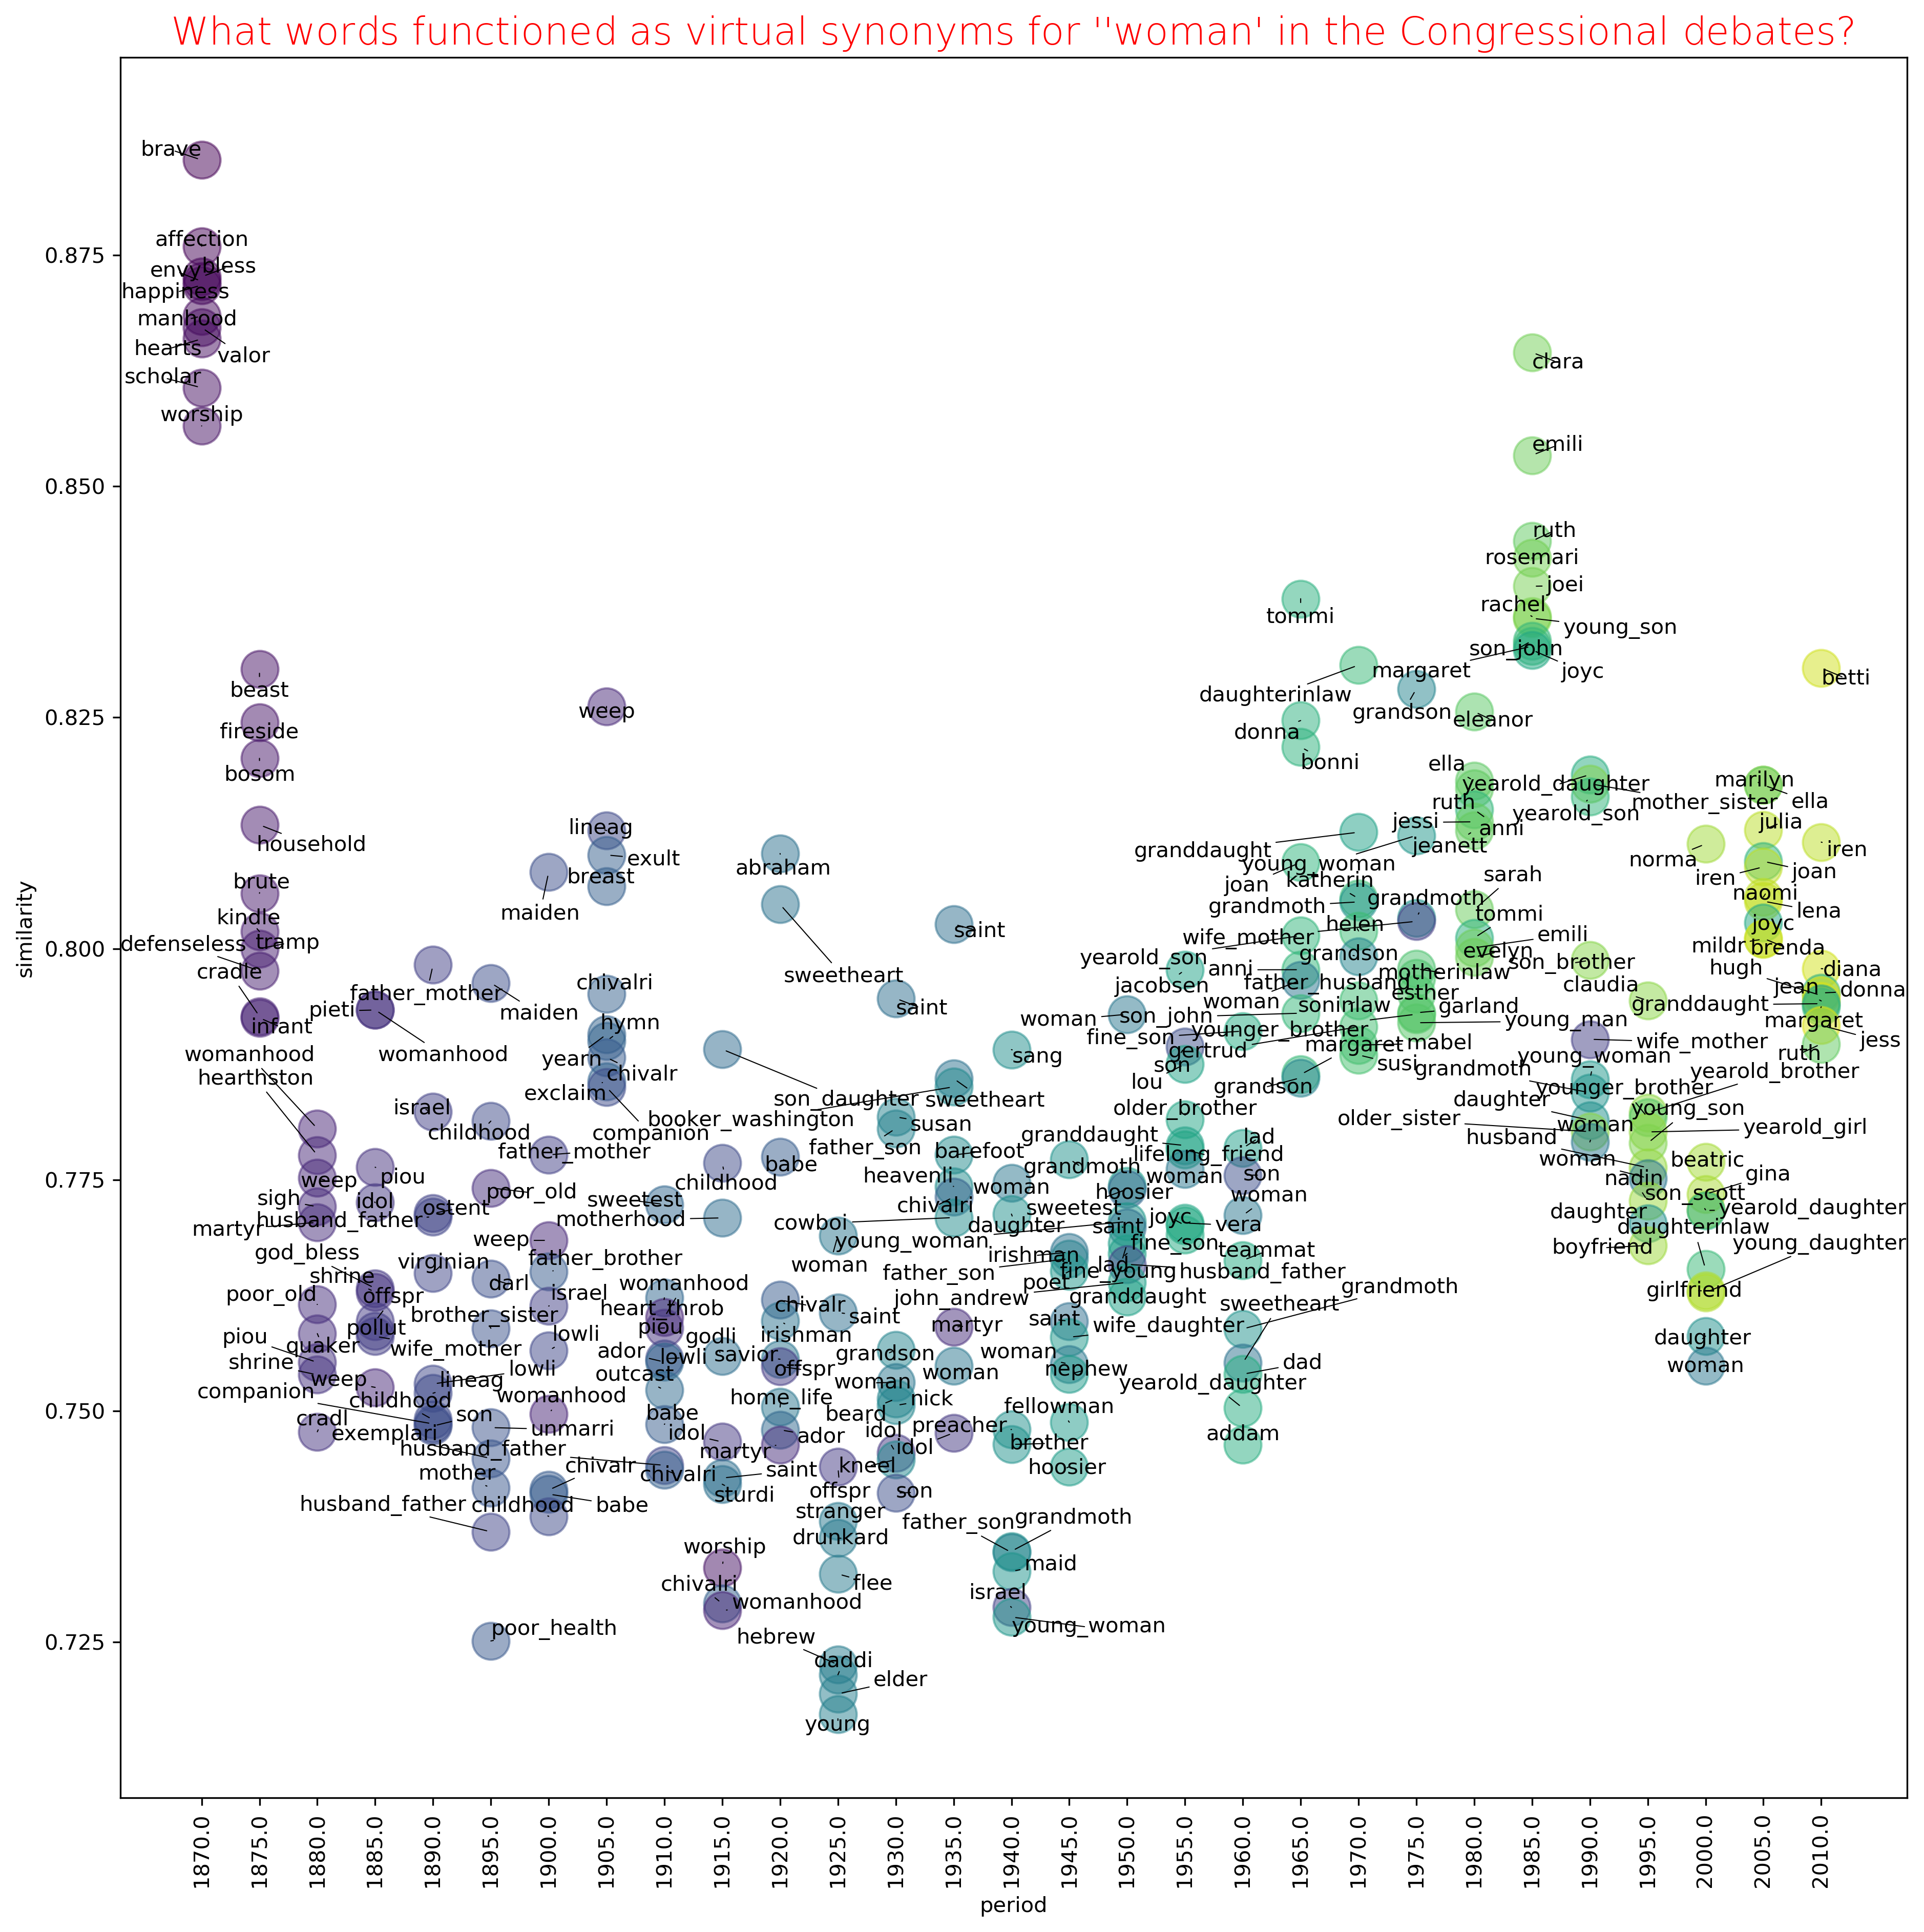

In [369]:
graph_context(synonyms, periodnames,  title2)
plt.savefig(keyword1 + filename + '-w-' + n + '-synonyms-over-time-' + str(startdate) + '-' + str(enddate) + '.pdf')

## Loop over multiple words

In [370]:
keyword_list = ['evaluation', 'operation', 'reevaluation', 'coordination', 'coordinate', 'price', 'control', 'rules', 'order', 'experts', 'creation', 'establishment',
                'reordering', 'recreation', 'worthy', 'faction', 'party', 'bias', 'biased', 'fair', 'unfair', 'chaotic', 'disorderly',
                'skin', 'natives', 'election', 'vote', 'voting', 'electioneering', 'populist', 'judicial', 'executive', 'administrative',
                'revitalize', 'hero', 'heroes', 'clergyman', 'businessman', 'business', 'busy', 'idle', 'mothers', 'fathers', 'mother', 'father', 'parents',   'progressive', 'industry', 'industrialization', 'factory', 'factories', 'family', 'america', 'american', 'popular', 'music', 'feminist', 'feminism', 
                'neh', 'nea', 'nsf', 'fed', 'fcc', 'ftc', 'epa', 'prison', 'jail', 'bail', 'incarcerated', 'incarceration', 'penalty', 'crime', 'criminal', 'criminals', 'crimes', 'prisons', 
                'progressivism', 'woman', 'women', 'man', 'men', 'territory', 'empire', 'colony', 'colonies', 'empires', 'tyranny', 'dictator', 'dictatorship', 'authoritarianism', 'war', 'security', 'deterrence', 'reorganization', 'overhaul', 'equalization', 'opportunity', 'vitality', 'space', 'place', 'city', 'nature', 'child', 'children', 'kids', 'death', 'life', 'army', 'navy', 'battle', 'wounds',
                'culture', 'freedom', 'democracy', 'liberty', 'government', 'corruption', 'efficiency', 'reorganization', 'immigration', 'immigrant',
                'citizen', 'citizenship', 'ethnic', 'ethnicity', 'partisan', 'progressive', 'liberal', 'conservative', 'union', 'unity', 'states', 'federal', 'federalism',
                'constitution', 'landscape', 'barn', 'home', 'homestead', 'fence', 'train', 'factory', 'marsh', 'wasteland', 'wilderness', 'nature', 
                'village', 'community', 'town', 'city', 'suburb', 'trolley', 'commuter', 'mine', 'forest', 'tenement', 'office', 'building', 'cities',
                'reform', 'independence', 'racism', 'prosperity', 'competition', 'lincoln', 'jefferson', 'roosevelt', 'fdr', 'eisenhower', 'congress', 'reagan', 'jfk', 'kennedy',
                'environment', 'environmental', 'environmentalist', 'natural', 'green', 'sustainable',
                'carbon', 'greenhouse', 'pollution', 'pollutor', 'solar', 'oil', 'fuel', 'gasoline', 'gas',
                'disobedience', 'contaminant', 'equality', 'inclusiveness', 'spirituality', 'coexistence', 'correctness', 'fundamentalism', 'values', 'economy',
                'tolerance', 'antisemitism', 'pluralism', 'market', 'homeowners', 'taxpayers', 'divine', 'slavery', 'jewish', 'synagogue', 'ignorance', 'intolerance', 'freedom', 'liberty', 'unity', 'pluralism',
                'socialism', 'church', 'religion', 'democracy', 'people', 'socialist', 'communist', 'capitalism', 'capitalist', 'christian', 'christianity', 'republican', 'taxation', 'taxes', 'property', 'land', 'rights', 'white', 'black', 'race', 'borders', 'border', 'party', 'president', 'war', 'money', 'peace',   'democract', 'women', 'men', 'mother', 'widow', 'female', 'feminine', 'girl']

In [ ]:
for keyword1 in keyword_list:

    keyword_context = []
    dates_found = []
    
    keyword_context = get_keyword_context(keyword1, filename)
    
    title1 = "What words used most in the context of ''" + keyword1 +  "' in the Congressional debates?"
    
    graph_context(keyword_context, periodnames, title1)
    plt.savefig(keyword1 + '-over-time-' + str(startdate) + '-' + str(enddate) + filename + '.pdf')

working on  1870.0
working on  1875.0
working on  1880.0
working on  1885.0
working on  1890.0
working on  1895.0
working on  1900.0
working on  1905.0
working on  1910.0
working on  1915.0
working on  1920.0
working on  1925.0
working on  1930.0
working on  1935.0
working on  1940.0
working on  1945.0
working on  1950.0
working on  1955.0
working on  1960.0
working on  1965.0
working on  1970.0
working on  1975.0
working on  1980.0
working on  1985.0
working on  1990.0
working on  1995.0
working on  2000.0
working on  2005.0
working on  2010.0
working on  1870.0
found  operation
working on  1875.0
found  operation
working on  1880.0
working on  1885.0
working on  1890.0
working on  1895.0
working on  1900.0
working on  1905.0
working on  1910.0
working on  1915.0
working on  1920.0
working on  1925.0
working on  1930.0
working on  1935.0
working on  1940.0
working on  1945.0
working on  1950.0
working on  1955.0
working on  1960.0
found  operation
working on  1965.0
found  operation
w

# Loop for plotting changing subtraction vectors, e.g. the difference between women and men, over time

In [27]:
keywordpairs = [['american', 'foreign'], ['white', 'black'], 
                ['white', 'ethnic'], ['mothers', 'fathers'], ['mother', 'father'], ['parents', 'children'], ['slave', 'free'], ['imprisoned', 'free'], ['consultation', 'cooperation'],
                ['networking', 'linkages'], ['teamwork', 'networking'], ['teamwork', 'partnerships'], ['manage', 'oversee'], ['create', 'develop'], ['control', 'transparency'],
                ['freedom', 'servitude'], ['partisan', 'cooperative'], ['alive', 'dead'], ['american', 'european'], ['american', 'latino'], ['liberal', 'conservative'],
                ['conservative', 'progressive'], ['businessman', 'clergyman'], ['optimistic', 'cynical'], ['progressive', 'reactionary'], ['conservative', 'moderate'],
                ['liberal', 'moderate'], ['progressive', 'moderate'], ['radical', 'centrist'], ['leftwing', 'rightwing'], ['generous', 'stingy'], ['popular', 'unpopular'],
                ['militant', 'conciliatory'], ['judicial', 'executive'], ['judicial', 'congressional'], ['federal', 'municipal'], ['laws', 'constitution'], ['regulation', 'coordination'],
                ['regulate', 'coordinate'], ['procedure', 'law'], ['creation', 'establishment'],
                ['american', 'immigrant'], ['america', 'empire'], ['empire', 'colony'], ['america', 'colony']]
# ['heart', 'mind'], ['fair', 'unfair'], ['true', 'false'], ['truth', 'falsehood'], ['passion', 'reason'], ['orderly','disorderly'], ['home', 'abroad'], 

In [28]:
#keyword1 = 'pollution'  # define the keyword you're looking for. you can change this variable as many times as you want.

In [ ]:
#keyword2 = 'culture'

In [ ]:
for k in keywordpairs:
    
    keyword1 = k[0]
    keyword2 = k[1]
    
    keyword_context_k1 = []
    keyword_context_k2 = []

    dates_found = []
    
    for p in range(0,len(periodnames)):

        period1 = periodnames[p]
        print('working on ', keyword1, " ", keyword2, " : ", period1)
        period_model = gensim.models.Word2Vec.load(filename + str(period1)) # to load a saved model

        ## analysis
        if (keyword1 in period_model.wv.vocab) and (keyword2 in period_model.wv.vocab):        
            keyword1_context_period = period_model.wv[keyword1] # extract the context of how women were talked about in that period
            keyword2_context_period = period_model.wv[keyword2] # extract the context of how men were talked about in that period

            diff1 = keyword1_context_period - keyword2_context_period # keyword1 minus keyword2
            diff1 = period_model.wv.similar_by_vector(diff1, topn= 5000)

            diff2 = keyword2_context_period - keyword1_context_period # keyword2 minus keyword1
            diff2 = period_model.wv.similar_by_vector(diff2, topn= 5000)

            keyword_context_k1.append(diff1) # save the context of how keyword1 was talked about for later
            keyword_context_k2.append(diff2) # save the context of how keyword2 was talked about for later

            dates_found.append(period1)
        else:
            keyword_context_k1.append([]) # save the context of how keyword1 was talked about for later
            keyword_context_k2.append([]) # save the context of how keyword2 was talked about for later
            dates_found.append([])
        
    # get distinct_dates
    distinct_dates = unique2(dates_found) 
    
    # optional - remove all instances of variations of keyword1 from keyword_context (so that we don't get 'taxation' as a collocate for 'tax') 
 #   keyword_context_k1_clean = remove_redundances(keyword_context_k1)
 #   keyword_context_k2_clean = remove_redundances(keyword_context_k2) 

    # visualize version 1
    print('making first visualization for ', keyword1, '-', keyword2)
    title1 = "What words were most associated with ''" + keyword1 + "' but not ''" + keyword2 + "' in Congressional debates?"
    graph_context(keyword_context_k1, periodnames, title1)
    plt.savefig(keyword1 + '-not-' + keyword2 + '-over-time-' + str(startdate) + '-' + str(enddate) + filename+ '.pdf')
    
    
     # visualize version 1
    print('making first visualization for ', keyword2, '-', keyword1)
    title2 = "What words were most associated with ''" + keyword2 + "' but not ''" + keyword1 + "' in Congressional debates?"
    graph_context(keyword_context_k2, periodnames, title2)
    plt.savefig(keyword2 + '-not-' + keyword1 + '-over-time-' + str(startdate) + '-' + str(enddate) + filename + '.pdf')


## Visualize the similarities betweem a group of words as a dendrogram

In [ ]:
#allwords3 = ['dream', 'bombing', 'warfare', 'racism', 'prosperity', 'wealth', 'happiness', 'today', 'tomorrow', 'past', 'present', 'future', 'america', 'france', 'britain', 'iraq', 'china', 'democratic', 'dictator', 'totalitarian', 'democracy', 'welfare', 'socialism', 'communism', 'russia', 'congress', 'debate', 'hearing', 'protest']

In [ ]:
congress_model = gensim.models.Word2Vec.load('congress_model-1870-2010') 

In [ ]:
# grab the top ten words from each year for a list
all_words = []
for i in range(0,len(dates_found)):
    words = [item[0] for item in keyword_context[i]][:10]
    all_words.append(words)

# flatten the list of lists
all_words2 = []
for list in all_words:
    for word in list:
        all_words2.append(word)

In [ ]:
# only unique words
# remove appearances of keyword1 in word (so no 'taxation' if 'tax' is keywords1)
import numpy as np
allwords3 = np.unique(all_words2)
allwords4 = []
for word in allwords3:
    if keyword1 not in word:
        if word in congress_model.wv.vocab:
            allwords4.append(word)
allwords4

In [ ]:
allwords4 = ['adams', 'buchanan','carter','eisenhower','ford', 'goldwater', 'gore',
             'hamilton','hatch', 'humphrey', 'jackson', 'javits', 'jefferson', 'johnson',
             'lyndon', 'mcgovern', 'nixon', 'roosevelt', 'kennedy',  
             'lincoln', 'washington', 'madison', 'taft', 'truman', 'vandenberg', 'wilson']
keyword1 = 'presidents'

In [ ]:
cd '/scratch/group/history/hist_3368-jguldi/congress-embeddings'

In [ ]:
congress_model = gensim.models.Word2Vec.load('congress_model-1870-2010') 

In [ ]:
keyword_vectors = congress_model.wv[allwords4] # [keywords]

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage #, set_link_color_palette
links = linkage(keyword_vectors, method='complete', metric='seuclidean')

In [ ]:
#colors 
from matplotlib import cm
from numpy import linspace
colors = [ str(cm.gnuplot(x)) for x in linspace(.5, 2, len(allwords4)) ]
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

#for color in colors:
#    color = color_map_color(color)
#colors
#set_link_color_palette(colors)



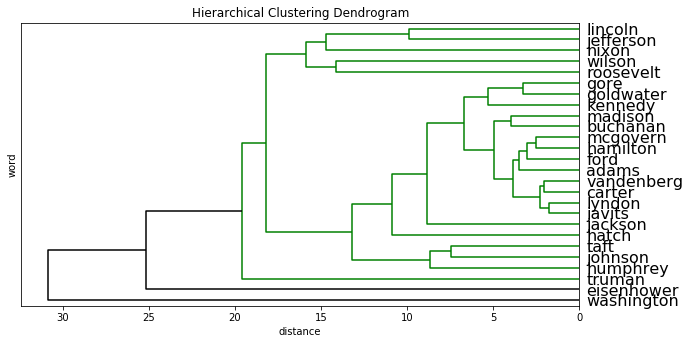

In [47]:
from matplotlib import pyplot as plt

l = links

# calculate full dendrogram
plt.figure(figsize=(10, len(allwords4)/5))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=16,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(allwords4[v]),
    #color_threshold=0, above_threshold_color='k'
    above_threshold_color='black'
)
#plt.show()

plt.gcf()
plt.savefig(keyword1 + '-dendrogram-' + str(startdate) + '-' + str(enddate) + filename+'.pdf', format = 'pdf', 
            bbox_inches='tight')

## Dendrogram per period

In [ ]:
keyword1 = 'environmentalist'

In [ ]:
keyword_context_period[:10]

In [ ]:
all_words = [item[0] for item in keyword_context_period[:30]]
all_words

In [ ]:
    allwords2 = []
    # make sure those words are in the model
    for word in all_words:
        if keyword1 not in word:
            if word in period_model.wv.vocab:
                allwords2.append(word)
    allwords2

In [ ]:
for period1 in periodnames:

    print('working on ', period1)
    period_model = gensim.models.Word2Vec.load('model-' + str(period1)) # to load a saved model
    
     ## analysis
    if keyword1 in period_model.wv.vocab:
            print('found ', keyword1)
            keyword_context_period = period_model.wv.most_similar(keyword1, topn = 5000) # extract the context of how women were talked about in that period
        
    # grab the top ten words from each year for a list
    all_words = [item[0] for item in keyword_context_period[:30]]
    
    allwords2 = []
    # make sure those words are in the model
    for word in all_words:
        if keyword1 not in word:
            if word in period_model.wv.vocab:
                allwords2.append(word)
    allwords2
    
    if len(allwords2) > 2:
        keyword_vectors = period_model.wv[allwords2] # [keywords]
        l = linkage(keyword_vectors, method='complete', metric='seuclidean')

        # calculate full dendrogram
        plt.figure(figsize=(10, len(allwords4)/5))
        plt.title('Context for the Word ' + keyword1.capitalize() + ' in ' + str(int(float(period1))))
        plt.ylabel('word')
        plt.xlabel('distance')

        dendrogram(
            l,
            leaf_rotation=0,  # rotates the x axis labels
            leaf_font_size=16,  # font size for the x axis labels
            orientation='left',
            leaf_label_func=lambda v: str(all_words[v]),
            #color_threshold=0, above_threshold_color='k'
            above_threshold_color='black'
        )
        #plt.show()

        plt.gcf()
        plt.savefig(keyword1 + '-dendrogram-' + str(period1) + '.pdf', format = 'pdf', 
                    bbox_inches='tight')

In [ ]:
# PLAYING WITH DENDROGRAMS -- INCOMPLETE

In [281]:
links2 = pd.DataFrame(l)
links3 = pd.concat([links2, pd.DataFrame(allwords4)], axis = 1)
links3.columns = ['a', 'b', 'c', 'd', 'label']

0      1          2     3                0
0    44.0   87.0   3.902968   2.0   administration
1    38.0   91.0   4.807257   3.0   appropriations
2     2.0   49.0   5.197940   2.0     cheeseparing
3    15.0   17.0   5.539578   2.0  competitiveness
4    68.0   92.0   5.563399   4.0     conservatism
..    ...    ...        ...   ...              ...
86  171.0  174.0  17.919182  50.0     wastefulness
87  172.0  177.0  18.198109  61.0           watres
88  176.0  178.0  18.905824  76.0        wellbeing
89  175.0  179.0  20.552297  91.0           wisdom
90    NaN    NaN        NaN   NaN             zeal

[91 rows x 5 columns]

In [309]:
# Load required modules
import pandas as pd 
import scipy.spatial
import scipy.cluster
import numpy as np
import json
import matplotlib.pyplot as plt

In [308]:
from scipy.cluster import hierarchy
hierarchy.to_tree(l, rd=False)

# Create dictionary for labeling nodes by their IDs
labels = list(df.genes)
id2name = dict(zip(range(len(labels)), labels))

# Draw dendrogram using matplotlib to scipy-dendrogram.pdf
scipy.cluster.hierarchy.dendrogram(clusters, labels=labels, orientation='right')
plt.savefig("scipy-dendrogram.png")

# Create a nested dictionary from the ClusterNode's returned by SciPy
def add_node(node, parent ):
	# First create the new node and append it to its parent's children
	newNode = dict( node_id=node.id, children=[] )
	parent["children"].append( newNode )

	# Recursively add the current node's children
	if node.left: add_node( node.left, newNode )
	if node.right: add_node( node.right, newNode )

# Initialize nested dictionary for d3, then recursively iterate through tree
d3Dendro = dict(children=[], name="Root1")
add_node( T, d3Dendro )

# Label each node with the names of each leaf in its subtree
def label_tree( n ):
	# If the node is a leaf, then we have its name
	if len(n["children"]) == 0:
		leafNames = [ id2name[n["node_id"]] ]
	
	# If not, flatten all the leaves in the node's subtree
	else:
		leafNames = reduce(lambda ls, c: ls + label_tree(c), n["children"], [])

	# Delete the node id since we don't need it anymore and
	# it makes for cleaner JSON
	del n["node_id"]

	# Labeling convention: "-"-separated leaf names
	n["name"] = name = "-".join(sorted(map(str, leafNames)))
	
	return leafNames

label_tree( d3Dendro["children"][0] )

# Output to JSON
json.dump(d3Dendro, open("d3-dendrogram.json", "w"), sort_keys=True, indent=4)

In [296]:
import copy

n_points = keyword_vectors.shape[0]
clusters = [dict(node_id=i, left=i, right=i, members=[i], distance=0, log_distance=0, n_members=1) for i in range(n_points)]
for z_i in range(l.shape[0]):
    row = l[z_i]
    cluster = dict(node_id=z_i + n_points, left=int(row[0]), right=int(row[1]), members=[], log_distance=np.log(row[2]), distance=row[2], n_members=int(row[3]))
    #cluster["members"].extend(copy.deepcopy(members[cluster["left"]]))
    #cluster["members"].extend(copy.deepcopy(members[cluster["right"]]))
    clusters.append(cluster)

on_split = {c["node_id"]: [c["left"], c["right"]] for c in clusters}
up_merge = {c["left"]: {"into": c["node_id"], "with": c["right"]} for c in clusters}
up_merge.update({c["right"]: {"into": c["node_id"], "with": c["left"]} for c in clusters})


In [303]:
up_merge

{0: {'into': 0, 'with': 0},
 1: {'into': 1, 'with': 1},
 2: {'into': 2, 'with': 2},
 3: {'into': 3, 'with': 3},
 4: {'into': 4, 'with': 4},
 5: {'into': 5, 'with': 5},
 6: {'into': 6, 'with': 6},
 7: {'into': 7, 'with': 7},
 8: {'into': 8, 'with': 8},
 9: {'into': 9, 'with': 9},
 10: {'into': 10, 'with': 10},
 11: {'into': 11, 'with': 11},
 12: {'into': 12, 'with': 12},
 13: {'into': 13, 'with': 13},
 14: {'into': 14, 'with': 14},
 15: {'into': 15, 'with': 15},
 16: {'into': 16, 'with': 16},
 17: {'into': 94, 'with': 15},
 18: {'into': 18, 'with': 18},
 19: {'into': 144, 'with': 11},
 20: {'into': 20, 'with': 20},
 21: {'into': 21, 'with': 21},
 22: {'into': 138, 'with': 1},
 23: {'into': 131, 'with': 3},
 24: {'into': 24, 'with': 24},
 25: {'into': 25, 'with': 25},
 26: {'into': 26, 'with': 26},
 27: {'into': 140, 'with': 13},
 28: {'into': 28, 'with': 28},
 29: {'into': 29, 'with': 29},
 30: {'into': 30, 'with': 30},
 31: {'into': 102, 'with': 6},
 32: {'into': 32, 'with': 32},
 33: 

## Visualizing Abstract Relatedness with PCA

In [271]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [272]:
%matplotlib inline

# change the figure's size here
plt.figure(figsize=(5,5), dpi = 200)

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

<Figure size 1000x1000 with 0 Axes>

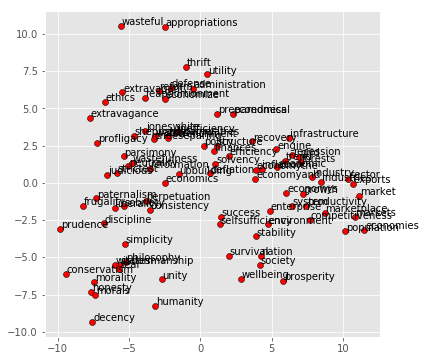

In [273]:
display_pca_scatterplot(congress_model.wv, allwords4)

## Assignment

In the code above, we learned how to streamline code to make it run over the complete data set.

Now that you can process *all* the data, you're ready for a more serious engagement with interpretation of historical questions, like:

* What are some of the ideas that changed in Congress over this time period? For instance, historians of this period frequently talk about the rise of a free-market ideology, a critique of the welfare state, arguments about the nature of democracy and America's role abroad. Can you support an argument about intellectual change on the basis of the changing context in which words were discussed?
* What groups of people were talked about in this period, and did the way they were spoken about change? Consider the role of women, minorities, the gay movement, and individuals who identify as religious in your answer.
* How did America's relationship with other nations change during this time period?  A historian might consider, for starters, the fall of the Berlin Wall in 1989 and the disintegration of the former USSR; the rise of terrorism, and the identification of Iraq, Iran, and Afghanistan as a frontier for US pacification; the border with Mexico and issues of immigration. Can you find systematic evidence of when and how one or more of these conversations changed in the data?

Choose one of the above questions. Iterate through a series of keyword queries and data results that would support a robust answer. Formulate an answer with at least one visualization and a page of writing, single-spaced, which analyze historical change in detail.

# Code in development

## Packed Circle Diagrams - NOT WORKING

In [267]:
!pip install squarify --user

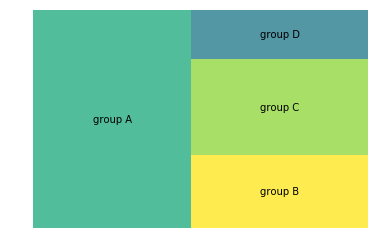

In [270]:
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd
# Create a data frame with fake data
df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })

# plot it
squarify.plot(sizes=df['nb_people'], label=df['group'], alpha=.8 )
plt.axis('off')
plt.show()


In [84]:
!pip install circlify --user
from pprint import pprint
import circlify

[Circle(x=-0.870435674782115, y=-0.07960900446544382, r=0.12593143431114334, level=1, ex={'datum': 1}),
 Circle(x=-0.5932602144828303, y=-0.20452975474670634, r=0.17809394233191544, level=1, ex={'datum': 2}),
 Circle(x=-0.6622462609299455, y=0.1943039587412656, r=0.21811964249692284, level=1, ex={'datum': 3}),
 Circle(x=-0.3256418302158876, y=-0.5410461134698134, r=0.2518628686222867, level=1, ex={'datum': 4}),
 Circle(x=-0.3805741891177557, y=0.607065170177418, r=0.2815912476237659, level=1, ex={'datum': 5}),
 Circle(x=0.23468265461951263, y=-0.5384228903031626, r=0.3084677566391192, level=1, ex={'datum': 6}),
 Circle(x=0.23395509820613103, y=0.624427401857965, r=0.3331832574329519, level=1, ex={'datum': 7}),
 Circle(x=-0.11242478710544043, y=0.028395903858600517, r=0.3561878846638309, level=1, ex={'datum': 8}),
 Circle(x=0.6215574004918205, y=0.028395903858600517, r=0.37779430293343, level=1, ex={'datum': 9}),
 Circle(x=0, y=0, r=1, level=1, ex=None)]


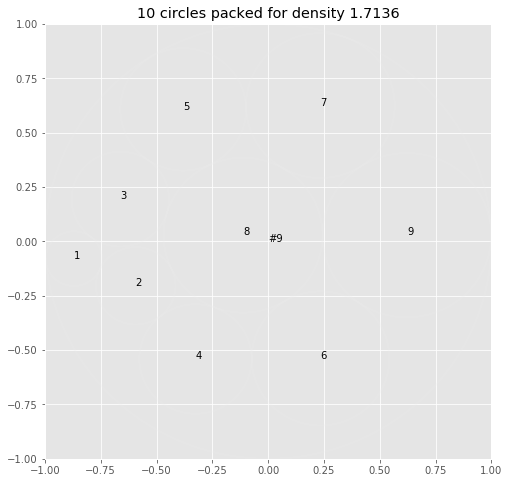

In [86]:
circles = circlify.circlify([9, 8, 7, 6, 5, 4, 3, 2, 1], show_enclosure=True, target_enclosure=circlify.Circle(x=0, y=0, r=1))
	# (necessary) data: A list of positive values sorted from largest to smallest
  	# (optional) target_enclosure: A target enclosure where the packed circles should fit (default to the unit circle (0, 0, 1))
  	# (optional) show_enclosure: A boolean indicating if the target enclosure should be appended to the output (default to False)

pprint(circles)
circlify.bubbles(circles=circles) # Graph of the packed circles

## IN DEVELOPMENT -- Search for categorized keywords

In [170]:
category_list = {'Governance':['tyranny', 'union', 'unity', 'government', 'federal', 'federalism', 'state', 'corruption', 'efficiency', 'taxation'],
                 'Freedom':['independence', 'freedom', 'equality'],
                 'Race':['race', 'citizen', 'citizenship', 'ethnic', 'ethnicity', 'inclusiveness', 'coexistence'],
                 'Party':['partisan', 'progressive', 'liberal', 'conservative', 'democratic', 'republican'],
                 'Presidents':['jfk', 'kennedy', 'roosevelt', 'washington', 'lincoln', 'eisenhower', 'reagan']}

In [197]:
for k in category_list.keys():
    print(k)
category_list[k]

Governance
Freedom
Race
Party
Presidents


['jfk',
 'kennedy',
 'roosevelt',
 'washington',
 'lincoln',
 'eisenhower',
 'reagan']

working on  heart   mind  :  1870.0
working on  heart   mind  :  1875.0
working on  heart   mind  :  1880.0
working on  heart   mind  :  1885.0
working on  heart   mind  :  1890.0
working on  heart   mind  :  1895.0
working on  heart   mind  :  1900.0
working on  heart   mind  :  1905.0
working on  heart   mind  :  1910.0
working on  heart   mind  :  1915.0
working on  heart   mind  :  1920.0
working on  heart   mind  :  1925.0
working on  heart   mind  :  1930.0
working on  heart   mind  :  1935.0
working on  heart   mind  :  1940.0
working on  heart   mind  :  1945.0
working on  heart   mind  :  1950.0
working on  heart   mind  :  1955.0
working on  heart   mind  :  1960.0
working on  heart   mind  :  1965.0
working on  heart   mind  :  1970.0
working on  heart   mind  :  1975.0
working on  heart   mind  :  1980.0
working on  heart   mind  :  1985.0
working on  heart   mind  :  1990.0
working on  heart   mind  :  1995.0
working on  heart   mind  :  2000.0
working on  heart   mind  : 

IndexError: list index out of range

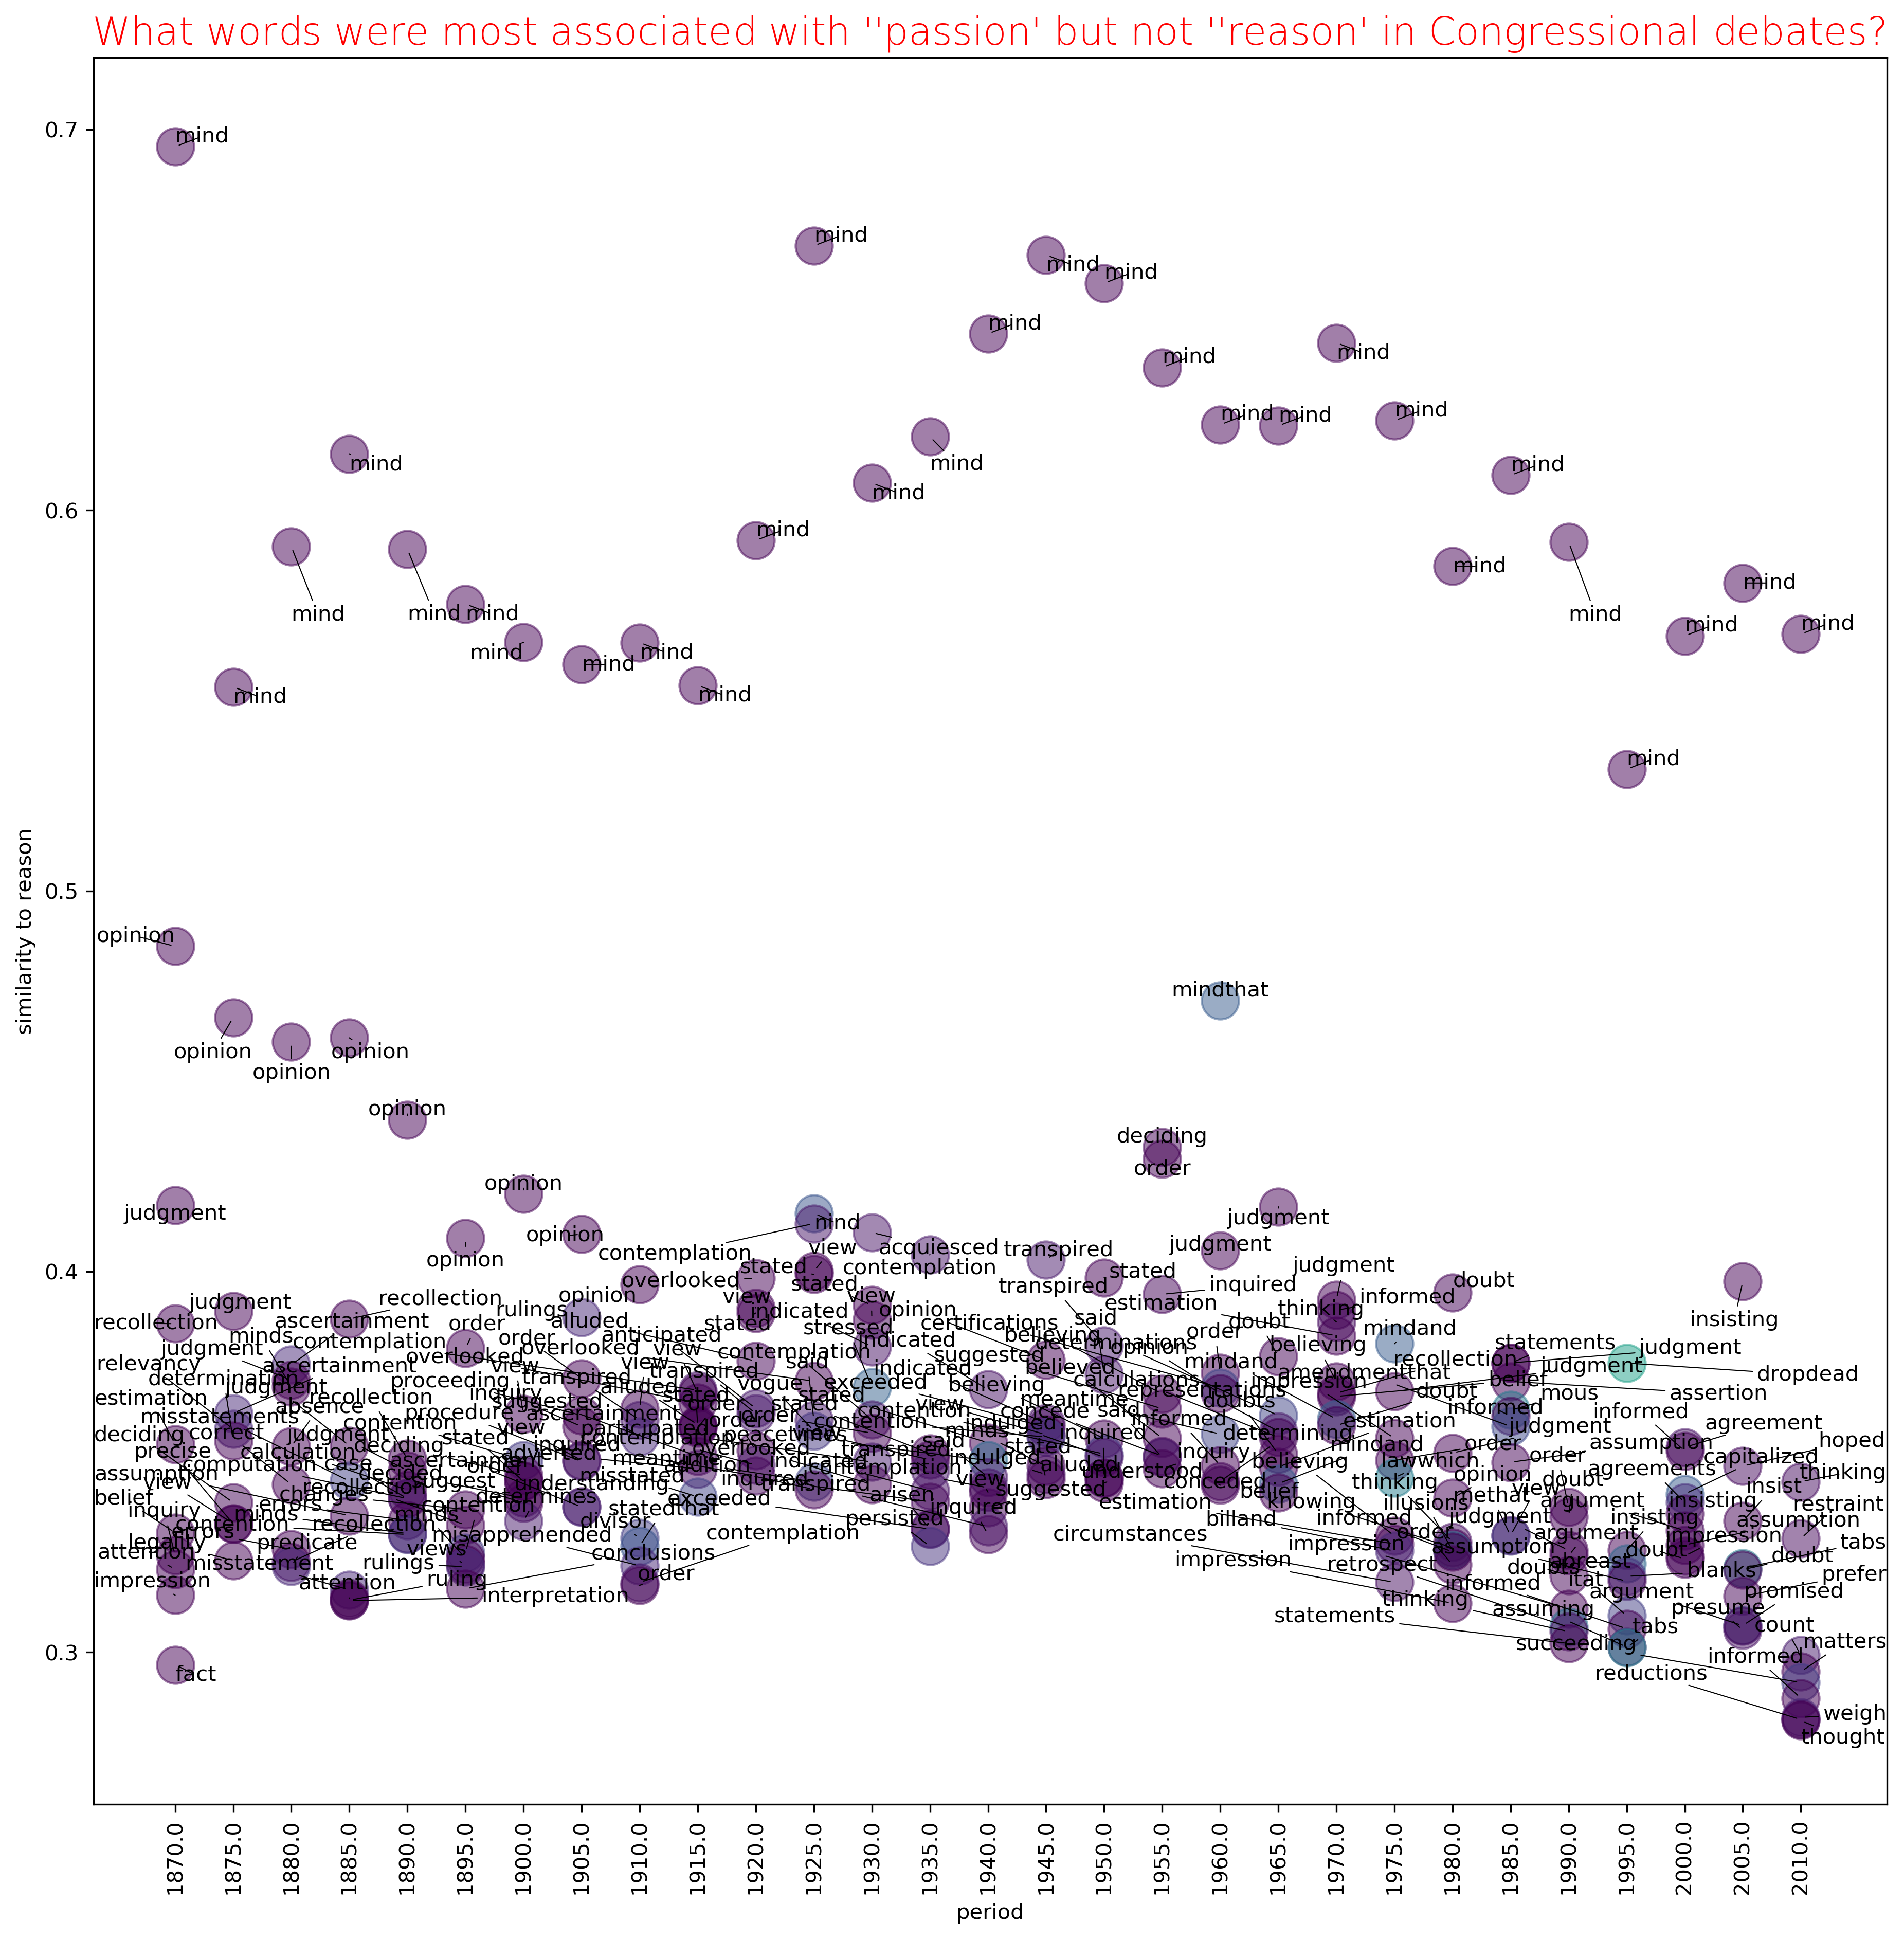

In [168]:
all_categories = 

for k in category_list.keys():
    print('working on ', k, ":", category_list[k])
    
    for p in range(0,len(periodnames)): # for each period in the model

        period1 = periodnames[p]
        vector_sum = []

        for w in category_list[k]: # cycle through the category 
            
            period_model = gensim.models.Word2Vec.load('model-' + str(period1)) # to load a saved model
            
            if (w in period_model.wv.vocab): # add up all word vectors for each word in the category
                
                keyword1_context_period = period_model.wv[w] # extract the context of how w was talked about in that period

                vector_sum = vector_sum + keyword1_context_period # add the vector for w
                
                dates_found.append(period1)
            
            else:
                vector_sum = vector_sum
                dates_found.append([])

        
        category_model = period_model.wv.similar_by_vector(vector_sum, topn= 5000)

        keyword_context.append(category_model) 
        
        all_categories[k]= keyword_context

            
    # optional - remove all instances of variations of keyword1 from keyword_context (so that we don't get 'taxation' as a collocate for 'tax') 
 #   keyword_context_k1_clean = remove_redundances(keyword_context_k1)
 #   keyword_context_k2_clean = remove_redundances(keyword_context_k2) 


    # get distinct_dates
    distinct_dates = unique2(dates_found) 
    
    # Add titles
    title1 = "What words were most associated with ''" + k + '" in Congressional debates?"
    graph_context(keyword_context, periodnames, title1)
      
    plt.savefig(k + '-as-category-over-time-' + str(startdate) + '-' + str(enddate) + '.pdf')
    

In [201]:
i

86